In [1]:
from scipy.integrate import odeint
from pylab import *
from lmfit import *
from scipy import stats
%matplotlib inline

# This results in all bare variable names printing output
# As suggested in https://www.dataquest.io/blog/jupyter-notebook-tips-tricks-shortcuts/
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import pandas as pd
#from IPython.display import display, HTML

# set up a dataframe for the results
labels = ['linear','PCB 118','PCB 153','PCB 138','PCB 20','PCB 70','PCB All','non-lin, calc']

zip = np.zeros(len(labels))
df = pd.DataFrame({"k (1/yr)":zip,  "+/-":zip,"r2":zip,'chi2':zip,"t0":zip,"+/-":zip},index=labels, \
                  columns = ["k (1/yr)","+/-","r2","chi2","t0","+/-"])

#print "Dataframe 1:"
#display(df)
#print "Dataframe 2:"
#HTML(df.to_html())
df

,k (1/yr),+/-,r2,chi2,t0,+/-
linear,0.0,0.0,0.0,0.0,0.0,0.0
PCB 118,0.0,0.0,0.0,0.0,0.0,0.0
PCB 153,0.0,0.0,0.0,0.0,0.0,0.0
PCB 138,0.0,0.0,0.0,0.0,0.0,0.0
PCB 20,0.0,0.0,0.0,0.0,0.0,0.0
PCB 70,0.0,0.0,0.0,0.0,0.0,0.0
PCB All,0.0,0.0,0.0,0.0,0.0,0.0
"non-lin, calc",0.0,0.0,0.0,0.0,0.0,0.0


In [2]:
# Test calculation of many cases
site = 'Site 3C'

# here  is how to print the key and value in a dict
#for k, v in sorted(norm.items()):
#    print k,v



In [3]:
# Load data from the selected site.
# This data comes from the spreadsheet "Inventories for C. Sherwood 12-16-2016.xlsx" which was modified
# and resent to CRS on 4/7/2016. The modifications added inventories of the congeners PCB28 and PBC70.
cols=["Year","DDE","DDMU","DDNU","PCB118","PCB153","PCB138","PCB28","PCB70"]
A=np.array([\
    [1981.27,1.34,0.07,0.004,0.0081,0.0062,0.0076,0.0025,0.0077],\
    [1992.51,0.71,0.25,0.012,0.0066,0.0049,0.0064,0.0017,0.0057],\
    [2003.58,0.39,0.32,0.036,0.0050,0.0037,0.0050,0.0012,0.0038],\
    [2009.23,0.38,0.52,0.069,0.0076,0.0076,0.0085,0.0030,0.0057],\
    [2010.31,0.41,0.52,0.085,0.0075,0.0072,0.0079,0.0033,0.0061]])
C3 = pd.DataFrame(A,columns=cols)

B=np.array([\
    [1992.52,3.07,0.67,0.026,0.0182,0.0119,0.0152,0.0084,0.0216],\
    [2003.58,2.75,0.87,0.072,0.0177,0.0122,0.0158,0.0106,0.0230],\
    [2009.23,2.37,0.75,0.095,0.0172,0.0095,0.0134,0.0112,0.0271],\
    [2010.31,1.16,0.43,0.046,0.0079,0.0054,0.0065,0.0032,0.0104]])
C6 = pd.DataFrame(B,columns=cols)

C3
C6

,Year,DDE,DDMU,DDNU,PCB118,PCB153,PCB138,PCB28,PCB70
0,1981.27,1.34,0.07,0.004,0.0081,0.0062,0.0076,0.0025,0.0077
1,1992.51,0.71,0.25,0.012,0.0066,0.0049,0.0064,0.0017,0.0057
2,2003.58,0.39,0.32,0.036,0.0050,0.0037,0.0050,0.0012,0.0038
3,2009.23,0.38,0.52,0.069,0.0076,0.0076,0.0085,0.0030,0.0057
4,2010.31,0.41,0.52,0.085,0.0075,0.0072,0.0079,0.0033,0.0061


,Year,DDE,DDMU,DDNU,PCB118,PCB153,PCB138,PCB28,PCB70
0,1992.52,3.07,0.67,0.026,0.0182,0.0119,0.0152,0.0084,0.0216
1,2003.58,2.75,0.87,0.072,0.0177,0.0122,0.0158,0.0106,0.0230
2,2009.23,2.37,0.75,0.095,0.0172,0.0095,0.0134,0.0112,0.0271
3,2010.31,1.16,0.43,0.046,0.0079,0.0054,0.0065,0.0032,0.0104


In [4]:
# guess at std. error in measurements per conv. with R.E.
stde_DDE  = 0.05          #RE suggests 0.05
stde_DDMU = 0.1          #RE suggested 0.1
stde_DDNU = 0.1          #RE suggested 0.1
stde_PCB  = 0.2          # std. error of measurements is around 0.2


In [5]:
# Objective function to minimize, fit through origin, estimate decay rate
def residual(params, t, data, eps_data):
    C0 = data[0]
    k = params['decay_rate']
    model = C0*np.exp(-k*(t-t[0]))
    return (data-model)**2/eps_data**2

# Objective function to minimize, estimate origin and decay rate
def residual2(params, t, data, eps_data):
    C0 = params['init_conc']
    k = params['decay_rate']
    model = C0*np.exp(-k*(t-t[0]))
    return (data-model)**2/eps_data**2

# this routine requires weights (e.g., array with std. dev. of y values)
# Weights of one produce unweighted least-squares
def lfit_Press(x,y,sig,iverbose=1):   
    n = float(x.size)
    sx = np.sum(x/sig**2)
    sy = np.sum(y/sig**2)
    ss = sum(1./sig**2)
    sxoss = sx/ss
    syoss = sy/ss
    t = (1./sig)*(x-sx/ss)
    st2 = np.sum(t**2)
    b = np.sum( (t*y)/sig )/st2
    a = (sy-sx*b)/ss
    siga = np.sqrt((1.+sx**2/(ss*st2))/ss)
    sigb = np.sqrt(1./st2)
    chi2 = sum( ((y-a-b*x)/sig)**2 ) #PTVF eqn. 15.2.2
    sigdat= np.sqrt(chi2/(n-2))
    siga=siga*sigdat
    sigb=sigb*sigdat
    yhat = a+b*x
    r2 = np.sum((yhat-syoss)**2)/np.sum((y-syoss)**2)
    if(iverbose):
        print('Slope: {0:.3f} +- {1:.4f}\nIntercept: {2:.3f} +- {3:.4f}\nr2 = {4:.4f}; chi-square = {5:.3f}'\
              .format(b,sigb,a,siga,r2,chi2))
    return b,sigb,a,siga,r2,chi2


In [6]:
# set up table1
t1cols = ['Adj','3D rate','3C +/-','3C r2','3C chi2','6C rate','6C +/-','6C r2','6C chi2','Year 0']
t1rows = ["none","PCB118","PCB153","PCB138","PCB28","PCB70","All"]
table1 = pd.DataFrame(index=t1rows, columns=t1cols)

In [7]:
method = ['RPE','CRS']
for j in method:
    
    C3t = C3['Year']
    C3std = np.ones_like(C3t)
    C6t = C6['Year']
    C6std = np.ones_like(C6t)

    data = np.log(C3['DDE'])
    #print('\nSite 3C, no adjustment:')
    b,sb,a,sa,r2,chisq = lfit_Press(C3t,data,C3std,iverbose=0)      

    #print('\nSite 6C, no adjustment:')
    data = np.log(C6['DDE'])
    b2,sb2,a2,sa2,r22,chisq2 = lfit_Press(C6t,data,C6std,iverbose=0)
    
    # calculate the intersection of the two lines
    xs = (a - a2)/(b2-b)
    table1.ix['none']=['none',b,sb,r2,chisq,b2,sb2,r22,chisq2,xs]

    #print("\nAdjusting with adjusted with "+i+":")
    for i in t1rows[1:6]:
        facC3 = 1.
        facC6 = 1.
        if j == 'CRS':
            facC3 = mean(C3[i])
            facC6 = mean(C6[i])
            
        data = np.log(facC3*C3['DDE']/C3[i])
        #print('Site 3C adjusted with '+i+':')
        b,sb,a,sa,r2,chisq = lfit_Press(C3t,data,C3std,iverbose=0)      

        data = np.log(facC6*C6['DDE']/C6[i])
        #print('Site 6C adjusted with '+i+':')
        b2,sb2,a2,sa2,r22,chisq2 = lfit_Press(C6t,data,C6std,iverbose=0)

        # calculate the intersection of the two lines
        xs = (a - a2)/(b2-b)
        table1.ix[i]=[i,b,sb,r2,chisq,b2,sb2,r22,chisq2,xs]
    
    print(j)
    table1

RPE


,Adj,3D rate,3C +/-,3C r2,3C chi2,6C rate,6C +/-,6C r2,6C chi2,Year 0
none,none,-0.0429643,0.0062251,0.940752,0.0708341,-0.0380168,0.0269042,0.499586,0.288236,1690.44
PCB118,PCB118,-0.0395373,0.00372409,0.974074,0.0253507,-0.00972683,0.00287965,0.850851,0.00330209,1977.41
PCB153,PCB153,-0.0480329,0.00827968,0.918156,0.125307,-0.00655867,0.00580075,0.389944,0.0133991,1977.63
PCB138,PCB138,-0.0445194,0.00518334,0.960922,0.0491099,-0.00727865,0.00294873,0.752874,0.0034624,1976.76
PCB28,PCB28,-0.0501811,0.0133481,0.824901,0.325681,-0.0142964,0.0209118,0.189423,0.174137,1994.13
PCB70,PCB70,-0.0324467,0.00447804,0.945947,0.0366543,-0.0204801,0.00977634,0.686936,0.0380593,1981.02
All,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


CRS


,Adj,3D rate,3C +/-,3C r2,3C chi2,6C rate,6C +/-,6C r2,6C chi2,Year 0
none,none,-0.0429643,0.0062251,0.940752,0.0708341,-0.0380168,0.0269042,0.499586,0.288236,1690.44
PCB118,PCB118,-0.0395373,0.00372409,0.974074,0.0253507,-0.00972683,0.00287965,0.850851,0.00330209,1951.1
PCB153,PCB153,-0.0480329,0.00827968,0.918156,0.125307,-0.00655867,0.00580075,0.389944,0.0133991,1965.6
PCB138,PCB138,-0.0445194,0.00518334,0.960922,0.0491099,-0.00727865,0.00294873,0.752874,0.0034624,1961.02
PCB28,PCB28,-0.0501811,0.0133481,0.824901,0.325681,-0.0142964,0.0209118,0.189423,0.174137,1958.68
PCB70,PCB70,-0.0324467,0.00447804,0.945947,0.0366543,-0.0204801,0.00977634,0.686936,0.0380593,1875.41
All,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


'RPE'

Site 3C adjusted with PCB118:
Slope: -0.040 +- 0.0037
Intercept: 83.461 +- 7.4460
r2 = 0.9741; chi-square = 0.025
Site 6C adjusted with PCB118:
Slope: -0.010 +- 0.0029
Intercept: 24.514 +- 5.7706
r2 = 0.8509; chi-square = 0.003


'CRS'

Site 3C adjusted with PCB118:
Slope: -0.040 +- 0.0037
Intercept: 78.494 +- 7.4460
r2 = 0.9741; chi-square = 0.025
Site 6C adjusted with PCB118:
Slope: -0.010 +- 0.0029
Intercept: 20.331 +- 5.7706
r2 = 0.8509; chi-square = 0.003


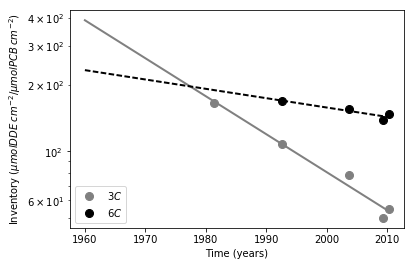

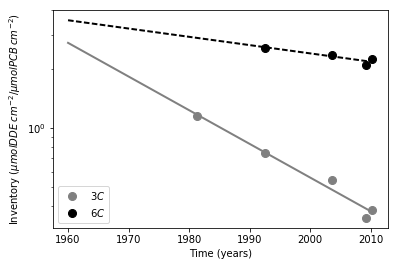

In [8]:
# suppress chatter from Matplotlib
#InteractiveShell.ast_node_interactivity = "none"

#ts1 = r"$k = {0:.2f}, r^2 = {0:5.3f}$".format(k1f_adj,r2_adj)
#ts2 = r"$k = {0:.2f}, r^2 = {0:5.3f}$".format(k1f,r2)
i='PCB118'
facC3 = 1.
facC6 = 1.
for j in method:
    j
    if j == 'CRS':
        facC3 = mean(C3[i])
        facC6 = mean(C6[i])

    C3data = np.log(facC3*C3['DDE']/C3[i])
    C6data = np.log(facC6*C6['DDE']/C6[i])

    print('Site 3C adjusted with '+i+':')
    b,sb,a,sa,r2,chisq = lfit_Press(C3t,C3data,C3std)
    hat = np.array((1960,2010))
    C3hat = exp( a+b*hat )

    data = np.log(facC6*C6['DDE']/C6[i])
    print('Site 6C adjusted with '+i+':')
    b2,sb2,a2,sa2,r22,chisq2 = lfit_Press(C6t,C6data,C6std)
    C6hat = exp( a2+b2*hat )

    # calculate the intersection of the two lines
    xs = (a - a2)/(b2-b)
    table1.ix[i]=[i,b,sb,r2,chisq,b2,sb2,r22,chisq2,xs]

    fig = plt.figure()
    plt.semilogy(hat,C3hat,'-',color='gray',linewidth=2) #,label=ts1)
    plt.semilogy(hat,C6hat,'--',color='black',linewidth=2) #,label=ts2)
    plt.semilogy(C3['Year'],exp(C3data),'o',color='gray',markersize=8,linestyle='None',label='$3C$')
    plt.semilogy(C6['Year'],exp(C6data),'o',color='black',markersize=8,linestyle='None',label='$6C$')
    plt.xlabel('Time (years)')
    plt.ylabel('Inventory ($\mu mol DDE \: cm^{-2} / \mu mol PCB \: cm^{-2} $)')
    plt.legend(loc='lower left')
    #plt.semilogy(t,DDE*adj_pcb118,'o',color='gray',markersize=8,linestyle='None',label='$DDE_{adj \: 118}$')